<a href="https://colab.research.google.com/github/rcordo/DataScienceEcosystem.ipynb/blob/master/WatsonX_fine_tuning_bert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Some techniques for fine-tuning open source LLMs

## Inspiration from HuggingFace

https://huggingface.co/docs/transformers/perf_train_gpu_one

# Installs

In [ ]:
! pip install transformers[torch] datasets pynvml

# Imports

In [ ]:
from datasets import load_dataset
from transformers import (
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding,
    AutoModelForSequenceClassification,
    AutoTokenizer,
)

from pynvml import (
    nvmlInit,
    nvmlDeviceGetHandleByIndex,
    nvmlDeviceGetMemoryInfo,
    nvmlDeviceGetCount,
    nvmlDeviceGetName,
)
import torch


In [ ]:
def print_gpu_utilization():
    if torch.cuda.is_available():
        nvmlInit()
        deviceCount = nvmlDeviceGetCount()
        for i in range(deviceCount):
            handle = nvmlDeviceGetHandleByIndex(i)
            info = nvmlDeviceGetMemoryInfo(handle)
            print("Device", i, ":", nvmlDeviceGetName(handle))
            print(f"GPU memory occupied: {info.used//1024**2} MB.")
        torch.cuda.empty_cache()
        return info.used//1024**2


def print_summary(result):
    if torch.cuda.is_available():
        if result:
            print(f"Time: {result.metrics['train_runtime']:.2f}")
            print(f"Samples/second: {result.metrics['train_samples_per_second']:.2f}")
        return print_gpu_utilization()

# Load Model and Tokenizer

In [ ]:
MODEL_NAME = "bert-base-uncased"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

def get_blank_model(model_name, **kwargs):
    return AutoModelForSequenceClassification.from_pretrained(
        model_name,
        num_labels=kwargs.get('num_labels', 2),
        label2id={'not_entailment': 1, 'entailment': 0},
        id2label={0: 'entailment', 1: 'not_entailment'}
    )


In [ ]:
get_blank_model(MODEL_NAME)

# Data Prep

In [ ]:
split = ["train[:8000]", "validation[:2000]"]  # or split = ["train[:1%]", "test[:1%]"]

raw_train, raw_test = load_dataset(
    "glue", 'qnli',
    split=split,
)

raw_train = raw_train.filter(lambda x: x['label'] != -1)
raw_test = raw_test.filter(lambda x: x['label'] != -1)

assert len(raw_test) > 0 and len(raw_train) > 0

train = raw_train.map(
    lambda x: tokenizer(x["question"], x["sentence"], truncation=True,
                        padding="max_length", max_length=tokenizer.model_max_length - 2),
    batched=True,
)
test = raw_test.map(
    lambda x: tokenizer(x["question"], x["sentence"], truncation=True,
                        padding="max_length", max_length=tokenizer.model_max_length - 2),
    batched=True,
)

In [ ]:
train, test

(Dataset({
     features: ['question', 'sentence', 'label', 'idx', 'input_ids', 'token_type_ids', 'attention_mask'],
     num_rows: 8000
 }),
 Dataset({
     features: ['question', 'sentence', 'label', 'idx', 'input_ids', 'token_type_ids', 'attention_mask'],
     num_rows: 2000
 }))

In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import numpy as np

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)

    # Compute accuracy
    accuracy = accuracy_score(labels, predictions)

    # You could compute additional metrics here like precision, recall, f1...
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='weighted')

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
    }


In [ ]:
final_model_metrics = {}
initial_mb_used = print_summary(None)

Device 0 : NVIDIA A100-SXM4-40GB
GPU memory occupied: 449 MB.


# Vanilla Training

In [ ]:
default_args = {
    "output_dir": "ai_user_grp_tmp",
    "evaluation_strategy": "epoch",
    "num_train_epochs": 1,
    "per_device_train_batch_size": 32,
    "per_device_eval_batch_size": 32,
}

model = get_blank_model(MODEL_NAME, num_labels=2)

training_args = TrainingArguments(**default_args)
trainer = Trainer(
    model=model,
    train_dataset=train,
    eval_dataset=test,
    tokenizer=tokenizer,
    args=training_args,
    compute_metrics=compute_metrics
)
print(trainer.evaluate())
train_results = trainer.train()
final_metrics = trainer.evaluate()
final_model_metrics['vanilla'] = dict(
    train_time_seconds=train_results.metrics['train_runtime'],
    val_accuracy=final_metrics['eval_accuracy'],
    val_loss=final_metrics['eval_loss']
)
final_model_metrics['vanilla']['mb_used'] = print_summary(train_results)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'eval_loss': 0.7126302719116211, 'eval_accuracy': 0.5115, 'eval_precision': 0.2647371987951807, 'eval_recall': 0.5115, 'eval_f1': 0.3488961296725107, 'eval_runtime': 18.4861, 'eval_samples_per_second': 108.19, 'eval_steps_per_second': 3.408}


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.338330,0.851000,0.851507,0.851000,0.851036


# Gradient Accumulation

Pass smaller batche sizes through the model but wait to perform backpropagation until we've accumulated gradients for a few batches

In [ ]:
default_args["per_device_train_batch_size"] = int(default_args["per_device_train_batch_size"] / 2)
default_args["gradient_accumulation_steps"] = 2

print(default_args)

# 16 batch size accumulated every 2 steps is an "Effective" batch size of 32, same as vanilla
# This is a massive save on memory usage during training especially on GPUs

model = get_blank_model(MODEL_NAME, num_labels=2)

training_args = TrainingArguments(**default_args)
trainer = Trainer(
    model=model,
    train_dataset=train,
    eval_dataset=test,
    tokenizer=tokenizer,
    args=training_args,
    compute_metrics=compute_metrics
)
print(trainer.evaluate())
train_results = trainer.train()
final_metrics = trainer.evaluate()
final_model_metrics['gradient_accumulation'] = dict(
    train_time_seconds=train_results.metrics['train_runtime'],
    val_accuracy=final_metrics['eval_accuracy'],
    val_loss=final_metrics['eval_loss']
)
final_model_metrics['gradient_accumulation']['mb_used'] = print_summary(train_results)

# Dynamic Padding

Instead of padding all examples to the same size at the beginning, dynamic padding will pad each batch to the longest element *in the batch*

This is also a big saver on memory so you can train with more data and with larger models on the same hardware

In [ ]:
collate_fn = DataCollatorWithPadding(tokenizer=tokenizer, padding="longest")
dynamic_pad_train = raw_train.map(
    lambda x: tokenizer(x["question"], x["sentence"], truncation=True, max_length=tokenizer.model_max_length - 2),
    batched=True,
)
dynamic_pad_test = raw_test.map(
    lambda x: tokenizer(x["question"], x["sentence"], truncation=True, max_length=tokenizer.model_max_length - 2),
    batched=True,
)
model = get_blank_model(MODEL_NAME, num_labels=2)

training_args = TrainingArguments(**default_args)

trainer = Trainer(
    model=model,
    train_dataset=dynamic_pad_train,
    eval_dataset=dynamic_pad_test,
    tokenizer=tokenizer,
    args=training_args,
    compute_metrics=compute_metrics,
    data_collator=collate_fn  # NEW
)
print(trainer.evaluate())
train_results = trainer.train()
final_metrics = trainer.evaluate()
final_model_metrics['grad_accum_plus_dynamic_padding'] = dict(
    train_time_seconds=train_results.metrics['train_runtime'],
    val_accuracy=final_metrics['eval_accuracy'],
    val_loss=final_metrics['eval_loss']
)
final_model_metrics['grad_accum_plus_dynamic_padding']['mb_used'] = print_summary(train_results)

In [ ]:
trainer.save_model()

# Model Freezing

Specifically stop all gradient accumulation for a portion of the model (usually the beginning layers)

In [ ]:
model = get_blank_model(MODEL_NAME, num_labels=2)

# NEW
for name, parameter in model.named_parameters():
    if 'bert.encoder.layer.6' in name:
        break
    parameter.requires_grad = False  # freezes the individual parameters


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
training_args = TrainingArguments(**default_args)

trainer = Trainer(
    model=model,
    train_dataset=dynamic_pad_train,
    eval_dataset=dynamic_pad_test,
    tokenizer=tokenizer,
    args=training_args,
    compute_metrics=compute_metrics,
    data_collator=collate_fn
)

print(trainer.evaluate())
train_results = trainer.train()
final_metrics = trainer.evaluate()
final_model_metrics['grad_accum_plus_dynamic_padding_plus_frozen'] = dict(
    train_time_seconds=train_results.metrics['train_runtime'],
    val_accuracy=final_metrics['eval_accuracy'],
    val_loss=final_metrics['eval_loss']
)
final_model_metrics['grad_accum_plus_dynamic_padding_plus_frozen']['mb_used'] = print_summary(train_results)

{'eval_loss': 0.7551637887954712, 'eval_accuracy': 0.5145, 'eval_precision': 0.2654902402402402, 'eval_recall': 0.5145, 'eval_f1': 0.35024727632882147, 'eval_runtime': 2.9729, 'eval_samples_per_second': 672.751, 'eval_steps_per_second': 21.192}


Epoch,Training Loss,Validation Loss


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.370204,0.838000,0.839612,0.838000,0.838000


Time: 26.08
Samples/second: 306.75
Device 0 : NVIDIA A100-SXM4-40GB
GPU memory occupied: 9425 MB.


In [ ]:
final_model_metrics

{'vanilla': {'train_time_seconds': 190.9688,
  'val_accuracy': 0.851,
  'val_loss': 0.33832988142967224,
  'mb_used': 24233},
 'gradient_accumulation': {'train_time_seconds': 197.6325,
  'val_accuracy': 0.843,
  'val_loss': 0.3657376170158386,
  'mb_used': 14853},
 'grad_accum_plus_dynamic_padding': {'train_time_seconds': 36.744,
  'val_accuracy': 0.837,
  'val_loss': 0.37069836258888245,
  'mb_used': 16225},
 'grad_accum_plus_dynamic_padding_plus_frozen': {'train_time_seconds': 26.0798,
  'val_accuracy': 0.838,
  'val_loss': 0.37020447850227356,
  'mb_used': 9425}}

<ipython-input-18-124b7c3e2664>:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


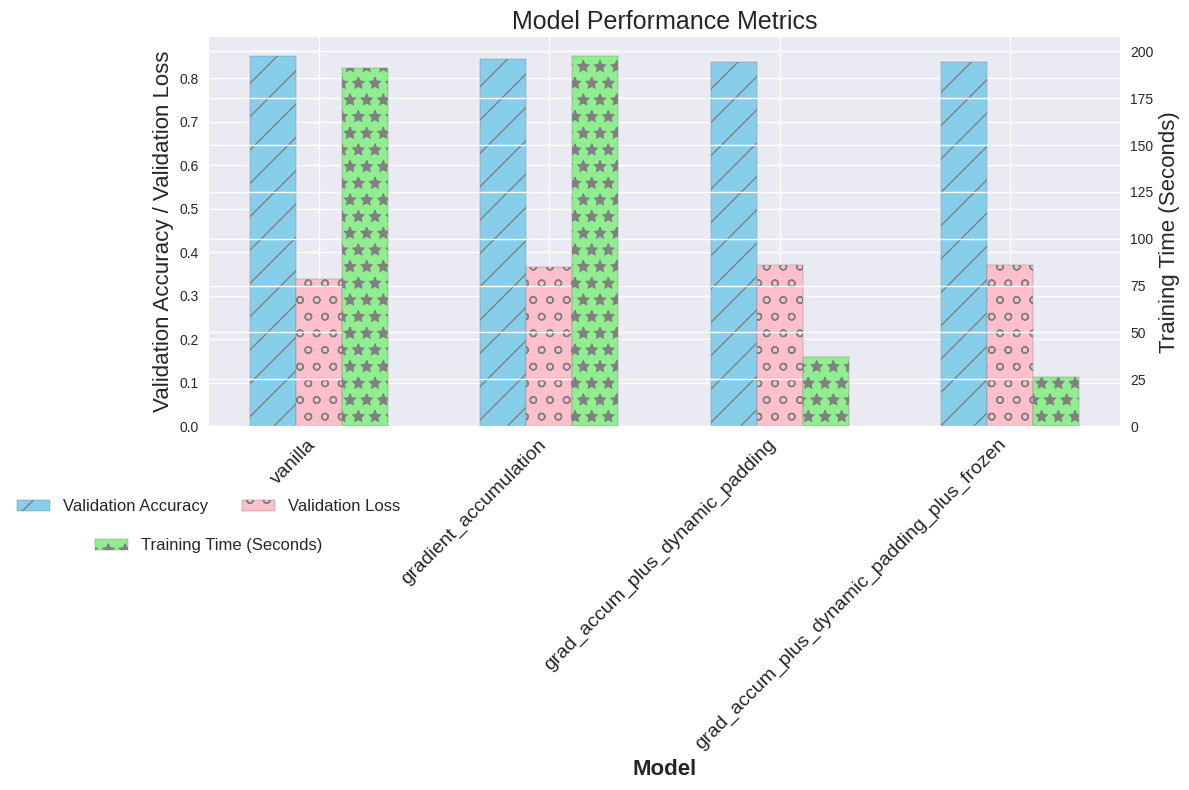

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Set up the style
plt.style.use('seaborn')

# Extract keys (model types) and values (metrics) from the dictionary
models = list(final_model_metrics.keys())
train_time_seconds = [metrics['train_time_seconds'] for metrics in final_model_metrics.values()]
val_accuracy = [metrics['val_accuracy'] for metrics in final_model_metrics.values()]
val_loss = [metrics['val_loss'] for metrics in final_model_metrics.values()]

# Define bar width
bar_width = 0.2

# Define the position of the bars
r1 = np.arange(len(train_time_seconds))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

# Create bar plot
fig, ax1 = plt.subplots(figsize=(12, 8))

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

# Colors and patterns
colors = ['skyblue', 'pink', 'lightgreen']
patterns = ['/', 'o', '*']

ax1.bar(r1, val_accuracy, color=colors[0], width=bar_width, edgecolor='grey', hatch=patterns[0], label='Validation Accuracy')
ax1.bar(r2, val_loss, color=colors[1], width=bar_width, edgecolor='grey', hatch=patterns[1], label='Validation Loss')
ax2.bar(r3, train_time_seconds, color=colors[2], width=bar_width, edgecolor='grey', hatch=patterns[2], label='Training Time (Seconds)')

# Adding xticks
ax1.set_xlabel('Model', fontweight='bold', fontsize=16)
ax1.set_xticks([r + bar_width for r in range(len(train_time_seconds))])
ax1.set_xticklabels(models, rotation=45, ha="right", fontsize=14)  # Rotate labels

# Setting y-axis labels
ax1.set_ylabel('Validation Accuracy / Validation Loss', fontsize=16)
ax2.set_ylabel('Training Time (Seconds)', fontsize=16)

# Adding legend with increased size
ax1.legend(loc='upper center', bbox_to_anchor=(0, -0.15), shadow=True, ncol=2, prop={'size': 12})
ax2.legend(loc='upper center', bbox_to_anchor=(0, -0.25), shadow=True, ncol=2, prop={'size': 12})

# Set title
plt.title('Model Performance Metrics', fontsize=18)

# Prevent label overlap
plt.tight_layout()
plt.show()


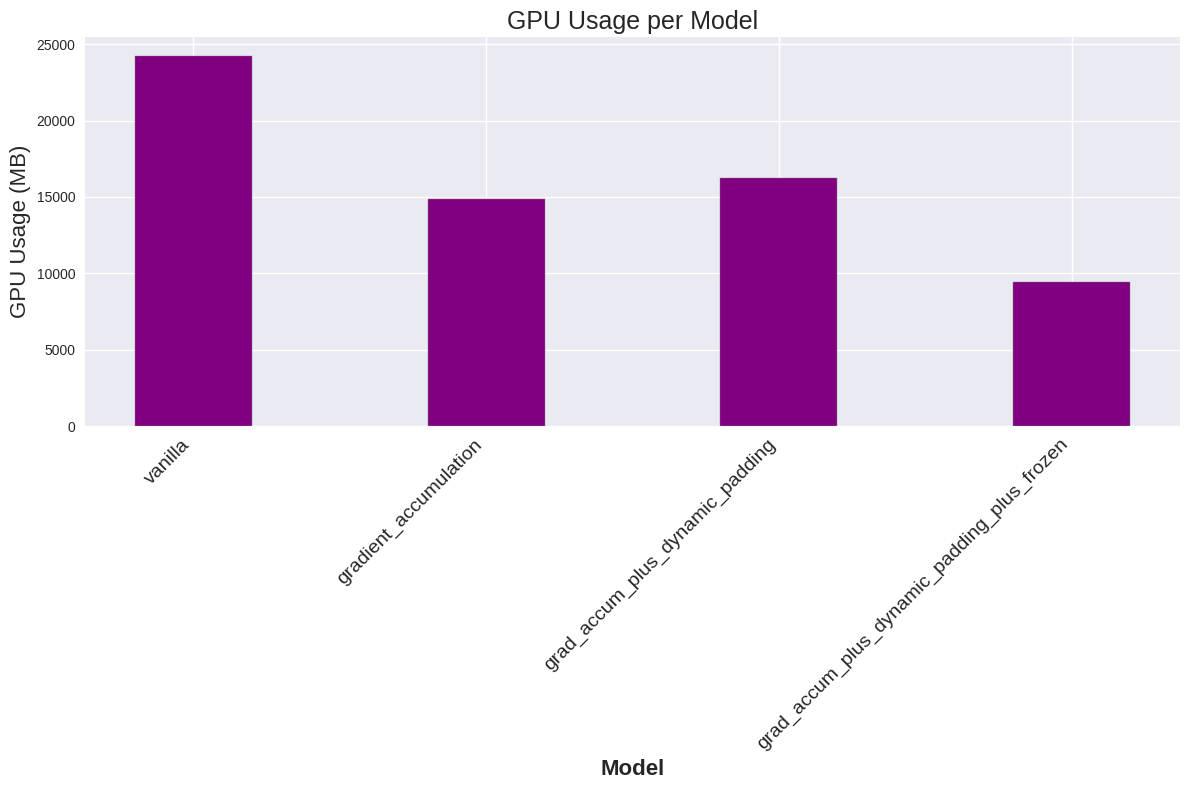

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Extract GPU usage data
mb_used = [metrics['mb_used'] for metrics in final_model_metrics.values()]  # GPU usage
models = list(final_model_metrics.keys())

# Define bar width and calculate positions for bars
bar_width = 0.4  # Adjust as needed
r4 = np.arange(len(mb_used))

# Create bar plot for GPU usage
fig, ax = plt.subplots(figsize=(12, 8))
ax.bar(r4, mb_used, color='purple', width=bar_width, edgecolor='grey', label='GPU Usage (MB)')

# Setting labels and title
ax.set_xlabel('Model', fontweight='bold', fontsize=16)
ax.set_xticks(r4)
ax.set_xticklabels(models, rotation=45, ha="right", fontsize=14)
ax.set_ylabel('GPU Usage (MB)', fontsize=16)

# Adding title
plt.title('GPU Usage per Model', fontsize=18)

# Layout adjustment
plt.tight_layout()

# Display the plot
plt.show()


In [ ]:
from transformers import pipeline
pipe = pipeline("text-classification", model=model, tokenizer=tokenizer, device=0)

pipe([
    {
        "text": 'How many people live in Berlin?',
        "text_pair": 'Berlin has a population of 3,520,031 in an area of 891.82 square kilometers.'
    },
    {
        "text": 'How many people live in Berlin?',
        "text_pair": 'New York City is famous for the Metropolitan Museum of Art.'
    },
    {
        "text": 'How many people live in Berlin?',
        "text_pair": 'Berlin is a wonderful city and has an area of 891.82 square kilometers.'
    }
])

[{'label': 'entailment', 'score': 0.7891486883163452},
 {'label': 'not_entailment', 'score': 0.9603387713432312},
 {'label': 'not_entailment', 'score': 0.9389755725860596}]

In [ ]:
from transformers import pipeline
import time

# Initialize the pipeline
pipe = pipeline("text-classification", model=model, tokenizer=tokenizer, device=0)

# Data for classification
data = [
    {
        "text": 'How many people live in Berlin?',
        "text_pair": 'Berlin has a population of 3,520,031 in an area of 891.82 square kilometers.'
    },
    {
        "text": 'How many people live in Berlin?',
        "text_pair": 'New York City is famous for the Metropolitan Museum of Art.'
    },
    {
        "text": 'How many people live in Berlin?',
        "text_pair": 'Berlin is a wonderful city and has an area of 891.82 square kilometers.'
    },
    {
        "text": "What is the capital of France?",
        "text_pair": "Paris is the capital of France and is renowned for its art, gastronomy, and culture."
    },
    {
        "text": "What is the capital of France?",
        "text_pair": "The Eiffel Tower is one of the most famous landmarks in Paris."
    },
    {
        "text": "Who wrote Macbeth?",
        "text_pair": "Macbeth is a tragedy by William Shakespeare, thought to have been first performed in 1606."
    },
    {
        "text": "Who wrote Macbeth?",
        "text_pair": "Shakespeare was an English playwright, widely regarded as the greatest writer in the English language."
    },
    {
        "text": "What is the boiling point of water?",
        "text_pair": "The boiling point of water is 100 degrees Celsius at sea level."
    },
    {
        "text": "What is the boiling point of water?",
        "text_pair": "Water freezes at 0 degrees Celsius and boils at 100 degrees Celsius."
    },
    {
        "text": "Who is the CEO of Tesla?",
        "text_pair": "Elon Musk, who is also the founder of SpaceX, is the CEO of Tesla."
    },
    {
        "text": "Who is the CEO of Tesla?",
        "text_pair": "Tesla, Inc. is an American electric vehicle and clean energy company."
    },
    {
        "text": "How far is the Moon from Earth?",
        "text_pair": "The average distance from the Moon to Earth is about 384,400 kilometers."
    },
    {
        "text": "How far is the Moon from Earth?",
        "text_pair": "The Moon orbits the Earth and is the Earth's only natural satellite."
    }
]

In [ ]:
import time

# Function to measure throughput
def measure_throughput(pipe, data, runs=5):
    throughputs = []
    for _ in range(runs):
        start_time = time.time()
        pipe(data)
        end_time = time.time()
        throughput = len(data) / (end_time - start_time)
        throughputs.append(throughput)

    return sum(throughputs) / len(throughputs)

# Measure average throughput
average_throughput = measure_throughput(pipe, data, runs=10)
print(f"Average Throughput: {average_throughput} inferences per second")


Average Throughput: 73.50982161827837 inferences per second


In [ ]:
ground_truth_labels = [
    "entailment",
    "not_entailment",
    "not_entailment",
    "entailment",
    "not_entailment",
    "entailment",
    "not_entailment",
    "entailment",
    "entailment",
    "entailment",
    "not_entailment",
    "entailment",
    "not_entailment"
]

predicted_labels = [p['label'] for p in pipe(data)]

# Calculate accuracy
correct_predictions = sum(pred_label == true_label for pred_label, true_label in zip(predicted_labels, ground_truth_labels))
accuracy = correct_predictions / len(ground_truth_labels)

print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 100.00%
